# Benchmarking conservative regridding

In this notebook we compare the results of three conservative regridding methods:
- The CDO (Climate Data Operators) command line program.
- The xESMF xarray extension (based on the Earth System Modelling Framework).
- a custom method, wrapped as an accessor by `xarray-regrid`. This method is based on [a post](https://discourse.pangeo.io/t/conservative-region-aggregation-with-xarray-geopandas-and-sparse/2715/3) by Stephan Hoyer.

The data to resample is the ERA5 monthly dataset, in this case the total precipitation.
Conservative regridding is more important for variables such as precipitation.

We start with importing the required modules, starting up Dask and loading in the data:

In [1]:
from time import time
import dask.distributed
import xarray_regrid  # Importing this will make Dataset.regrid accessible.
import xarray as xr
from xarray_regrid import Grid
import xesmf as xe
import warnings

warnings.filterwarnings('ignore')

client = dask.distributed.Client()

ds = xr.open_dataset(
    "data/era5_total_precipitation_2020_monthly.nc",
    chunks={"longitude": 400, "latitude": 400},
).persist()

Both `xarray-regrid` and `xESMF` require a dataset to resample to. For this you can also use an already existing dataset with the desired grid.

Here we use the `Grid` dataclass from `xarray-regrid` to create the dataset.

In [2]:
new_grid = Grid(
    north=90,
    east=360,
    south=-90,
    west=0,
    resolution_lat=2.2,
    resolution_lon=2.2,
)
target_dataset = new_grid.create_regridding_dataset()
target_dataset

<xarray.Dataset> Size: 2kB
Dimensions:    (latitude: 82, longitude: 164)
Coordinates:
  * latitude   (latitude) float64 656B -90.0 -87.8 -85.6 ... 83.8 86.0 88.2
  * longitude  (longitude) float64 1kB 0.0 2.2 4.4 6.6 ... 354.2 356.4 358.6
Data variables:
    *empty*

## xarray-regrid

With `xarray-regrid` you can access the regridding utilities by using `Dataset.regrid`.

To make the comparison fair the lazy dataset is computed, to actually have the regridding performed.

In [3]:
t0 = time()

data_regrid = ds.regrid.conservative(target_dataset, skipna=False, latitude_coord="latitude")
data_regrid = data_regrid.compute()

print(f"Elapsed time: {time() - t0:.3f} seconds")

Elapsed time: 1.289 seconds


## CDO

The CDO data was regridded using the terminal.

To ensure that the regridding is most accurate, the dataset was first converted to 64-bit floats:
 - `cdo -b 64 -copy era5_total_precipitation_2020_monthly.nc era5_total_precipitation_2020_monthly_64b.nc`
 - `cdo -b 64 -copy new_grid_con.nc new_grid_64b.nc`

Next, the data can be regridded:
 - `cdo remapcon,new_grid_64b.nc era5_total_precipitation_2020_monthly_64b.nc cdo_conservative_64b.nc`

Note that this notebook automatically goes through these steps:

In [4]:
import numpy as np

target_dataset["test_data"] = (
    ["latitude", "longitude"],
    np.zeros((target_dataset["latitude"].size, target_dataset["longitude"].size)),
)
target_dataset.to_netcdf("data/new_grid_con.nc")

!cdo -b 64 -copy data/era5_total_precipitation_2020_monthly.nc data/era5_total_precipitation_2020_monthly_64b.nc
!cdo -b 64 -copy data/new_grid_con.nc data/new_grid_64b.nc
!cdo remapcon,data/new_grid_64b.nc data/era5_total_precipitation_2020_monthly_64b.nc data/cdo_conservative_64b.nc

data_cdo = xr.open_dataset("data/cdo_conservative_64b.nc")

cdo    copy:      1 2 3 4 5 5 6 7 8 91cdo    copy: Processed 12458880 values from 1 variable over 12 timesteps [0.16s 159MB]
cdo    copy:   1cdo    copy: Processed 13448 values from 1 variable over 1 timestep [0.00s 158MB]
cdo    remapcon: YAC first order conservative weights from lonlat (1440x721) to lonlat (164x82) grid
cdo    remapcon:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapcon: Processed 12458880 values from 1 variable over 12 timesteps [1.66s 158MB]


## xESMF

For xESMF the regridding weights are first computed (`xe.Regridder`). 

After that, the regridder can be used to regrid the dataset:

In [5]:
t0 = time()
regridder = xe.Regridder(ds, target_dataset, "conservative")
print(f"Elapsed time generating weights: {time() - t0:.3f} seconds")

t0 = time()
data_esmf: xr.Dataset = regridder(ds, keep_attrs=True).compute()
print(f"Elapsed time regridding: {time() - t0:.3f} seconds")

Elapsed time generating weights: 22.020 seconds
Elapsed time regridding: 4.704 seconds


## Comparison

Now the data has been regridded using all three available methods, we can compare the results.

The following code block computes the relative error `(a-b)/a` between the three datasets. As you see, the method `xarray-regrid` uses has very similar results compared to the CDO regridding. xESMF seems deviate from the CDO result.

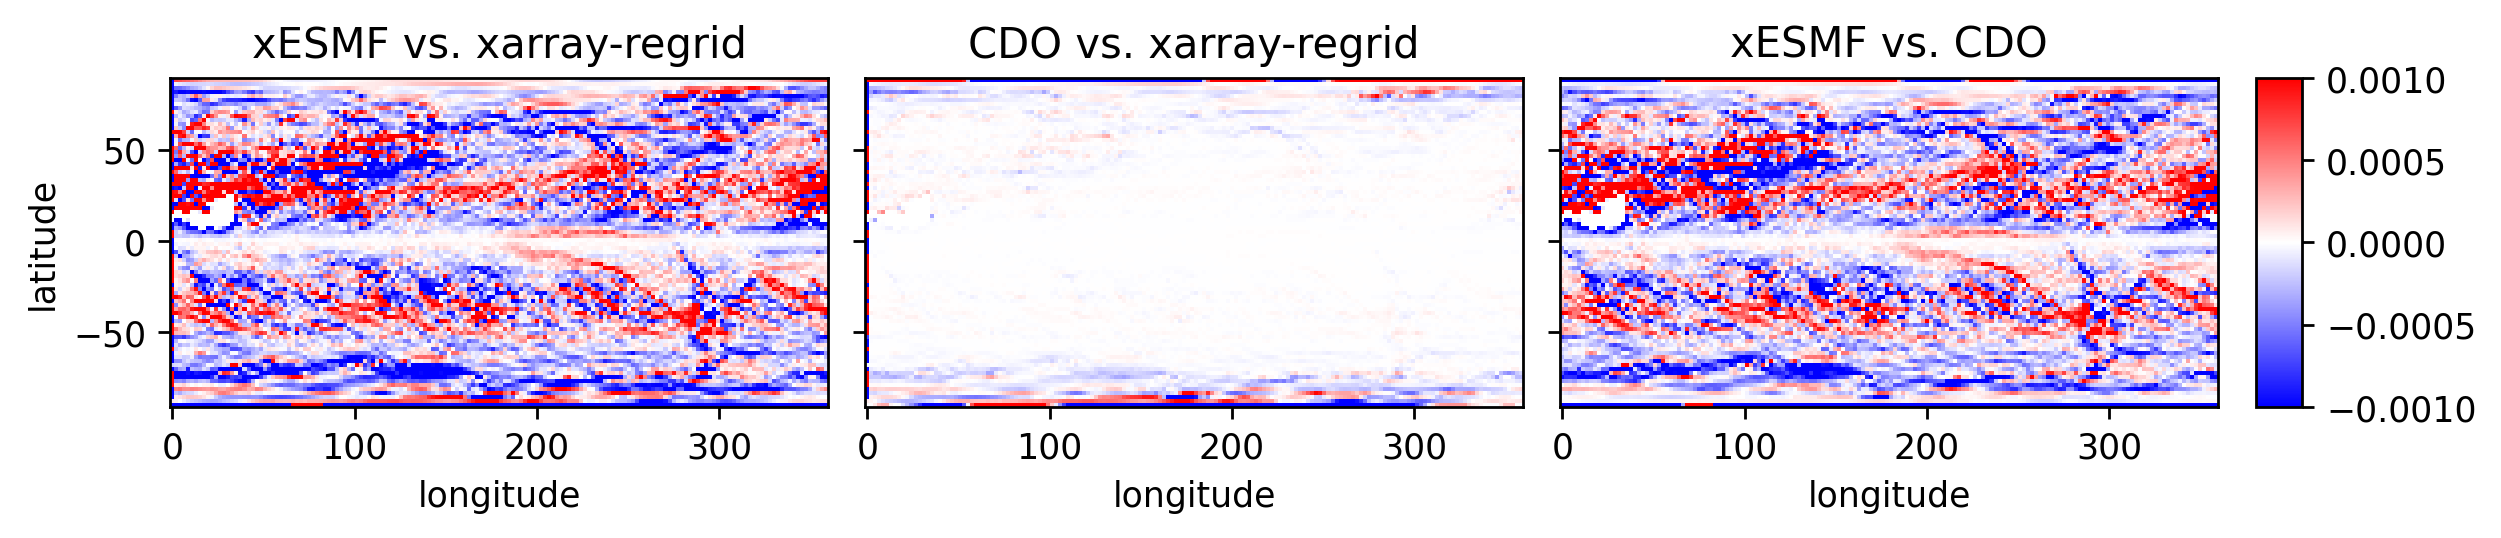

In [6]:
from benchmark_utils import plot_comparison

plot_comparison(data_regrid, data_esmf, data_cdo, vmin=-1e-3, vmax=1e-3, varname="tp")

We can calculate the root mean squared error as well:

Note: because of issues surrounding the edges (north/south/east/west) of the dataset, these were removed before calculating the RMSE.

In [7]:
import numpy as np

no_edges = dict(latitude=slice(-85, 85), longitude=slice(5, 355))

rmse = (
    np.sqrt(np.mean((data_regrid - data_cdo).sel(no_edges) ** 2))["tp"].to_numpy()
    * 1000
)
print(f"xarray-regrid vs. CDO - RMSE: {rmse:.5f} mm")

rmse = (
    np.sqrt(np.mean((data_esmf - data_cdo).sel(no_edges) ** 2))["tp"].to_numpy() * 1000
)
print(f"xESMF vs. CDO         - RMSE: {rmse:.5f} mm")

xarray-regrid vs. CDO - RMSE: 0.00007 mm
xESMF vs. CDO         - RMSE: 0.00161 mm


Compare the runtime and output of different `nan_threshold` values. You should consider disabling `skipna` if you are certain your dataset lacks NaN values.

In [8]:
ds_sst = xr.tutorial.open_dataset("ersstv5")[["sst"]].rename(lon="longitude", lat="latitude").persist()

new_grid = Grid(
    north=90,
    east=360,
    south=-90,
    west=0,
    resolution_lat=4,
    resolution_lon=4,
)
target_dataset = new_grid.create_regridding_dataset()

t0 = time()
data_skipna_false = ds_sst.regrid.conservative(target_dataset, skipna=False).compute()
print(f"Elapsed time skipna=False: {time() - t0:.3f} seconds")

t0 = time()
data_nt0 = ds_sst.regrid.conservative(target_dataset, skipna=True, nan_threshold=0).compute()
print(f"Elapsed time skipna=True: {time() - t0:.3f} seconds")

data_nt1 = ds_sst.regrid.conservative(target_dataset, skipna=True, nan_threshold=1).compute()


Elapsed time skipna=False: 0.408 seconds
Elapsed time skipna=True: 1.018 seconds
